In [15]:
from pathlib import Path

# Works whether notebook is in notebooks/ or root
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

DATA_DIR = PROJECT_ROOT / "data"
SRC_DIR = PROJECT_ROOT / "src"
TESTS_DIR = PROJECT_ROOT / "tests"

DATA_DIR.mkdir(exist_ok=True)
SRC_DIR.mkdir(exist_ok=True)
TESTS_DIR.mkdir(exist_ok=True)

DATA_PATH = DATA_DIR / "brisbane_water_quality.csv"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_PATH:", DATA_PATH)


PROJECT_ROOT: c:\Users\varun\Downloads\WaterQualityProject
DATA_PATH: c:\Users\varun\Downloads\WaterQualityProject\data\brisbane_water_quality.csv


In [16]:
assert DATA_PATH.exists(), (
    f"Dataset not found at {DATA_PATH}\n"
    "Put brisbane_water_quality.csv inside the data/ folder."
)
print("✅ Dataset found.")


✅ Dataset found.


In [17]:
# requirements.txt
(PROJECT_ROOT / "requirements.txt").write_text(
"""pandas
numpy
matplotlib
pytest
""",
encoding="utf-8"
)

# pytest.ini (CRITICAL so pytest can import src)
(PROJECT_ROOT / "pytest.ini").write_text(
"""[pytest]
pythonpath = .
testpaths = tests
""",
encoding="utf-8"
)

# README.md
(PROJECT_ROOT / "README.md").write_text(
"""# Water Quality Monitoring & Pollution Detection (Brisbane Dataset)

## Overview
This project analyzes publicly available sensor water-quality data and flags samples as **Safe** or **Unsafe** using a transparent risk-scoring model.

## Data
Place the dataset at:
`data/brisbane_water_quality.csv`

Dataset columns used:
- Timestamp
- Record number
- pH
- Turbidity
- Specific Conductance
- Dissolved Oxygen
- Temperature
- Salinity
- Chlorophyll
(+ optional quality columns like `pH[quality]`)

## Run (Single Notebook)
Open and run:
`notebooks/Run_Project.ipynb`

The notebook will:
1) generate Python modules in `src/`
2) generate pytest tests in `tests/`
3) load dataset and build WaterSample objects
4) evaluate risk scores and Safe/Unsafe labels
5) save results to `data/results.csv`
6) plot risk distribution and Safe vs Unsafe counts

## Tests
From terminal (or notebook):
`python -m pytest -q`
""",
encoding="utf-8"
)

print("✅ Wrote requirements.txt, pytest.ini, README.md")


✅ Wrote requirements.txt, pytest.ini, README.md


In [18]:
# src/__init__.py
(SRC_DIR / "__init__.py").write_text(
"""\"\"\"Water Quality Monitoring & Pollution Detection package.\"\"\"\n""",
encoding="utf-8"
)

# src/exceptions.py
(SRC_DIR / "exceptions.py").write_text(
"""\"\"\"Custom exceptions for the project.\"\"\"\n
class DataValidationError(Exception):
    \"\"\"Raised when the input data is missing required columns or has invalid values.\"\"\"
""",
encoding="utf-8"
)

# src/samples.py
(SRC_DIR / "samples.py").write_text(
"""\"\"\"Defines WaterSample and timestamp parsing.\"\"\"\n
from __future__ import annotations

from dataclasses import dataclass
from datetime import datetime
from typing import Optional

from .exceptions import DataValidationError


@dataclass(frozen=True, slots=True)
class WaterSample:
    \"\"\"Represents a single water sample record (sensor snapshot).

    Notes
    -----
    Includes:
    - validation
    - __str__ (Part 2)
    - operator overloading (__lt__) (Part 2)
    \"\"\"

    sample_id: str
    timestamp: Optional[datetime]

    ph: float
    turbidity: float
    conductivity: float
    dissolved_oxygen: float
    temperature: float
    salinity: float
    chlorophyll: float

    def validate(self) -> None:
        \"\"\"Validate ranges to catch obvious sensor/data errors.\"\"\"
        if not self.sample_id:
            raise DataValidationError("sample_id must be a non-empty string.")

        if not (0.0 <= float(self.ph) <= 14.0):
            raise DataValidationError(f"Invalid pH={self.ph}. Expected within [0, 14].")

        for name, val in [
            ("turbidity", self.turbidity),
            ("conductivity", self.conductivity),
            ("dissolved_oxygen", self.dissolved_oxygen),
            ("salinity", self.salinity),
            ("chlorophyll", self.chlorophyll),
        ]:
            if float(val) < 0.0:
                raise DataValidationError(f"Invalid {name}={val}. Expected >= 0.")

        if not (-5.0 <= float(self.temperature) <= 45.0):
            raise DataValidationError(f"Invalid temperature={self.temperature}. Expected within [-5, 45].")

    def __str__(self) -> str:
        ts = self.timestamp.isoformat() if self.timestamp else "NA"
        return (
            f"WaterSample(id={self.sample_id}, ts={ts}, ph={self.ph:.2f}, turb={self.turbidity:.2f}, "
            f"cond={self.conductivity:.2f}, DO={self.dissolved_oxygen:.2f}, temp={self.temperature:.2f}, "
            f"sal={self.salinity:.2f}, chl={self.chlorophyll:.2f})"
        )

    def __lt__(self, other: "WaterSample") -> bool:
        \"\"\"Operator overloading: allow sorting by timestamp then id.\"\"\"
        if not isinstance(other, WaterSample):
            return NotImplemented
        if self.timestamp and other.timestamp:
            return (self.timestamp, self.sample_id) < (other.timestamp, other.sample_id)
        return self.sample_id < other.sample_id


def parse_timestamp(value: object) -> Optional[datetime]:
    \"\"\"Parse timestamps from common formats (built-in datetime).\"\"\"
    if value is None:
        return None
    s = str(value).strip()
    if s == "" or s.lower() in {"na", "nan", "none"}:
        return None

    for fmt in ("%Y-%m-%d %H:%M:%S", "%Y-%m-%d", "%d/%m/%Y %H:%M:%S", "%d/%m/%Y"):
        try:
            return datetime.strptime(s, fmt)
        except ValueError:
            continue

    try:
        return datetime.fromisoformat(s)
    except ValueError:
        return None
""",
encoding="utf-8"
)

# src/loader.py
(SRC_DIR / "loader.py").write_text(
"""\"\"\"Load Brisbane water quality CSV and build WaterSample objects.\"\"\"\n
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional

import pandas as pd

from .exceptions import DataValidationError
from .samples import WaterSample, parse_timestamp


@dataclass(slots=True)
class DatasetLoader:
    \"\"\"Loads Brisbane water quality dataset CSV and constructs WaterSample objects.\"\"\"

    csv_path: Path
    column_map: Optional[Dict[str, str]] = None
    use_quality_filter: bool = True

    REQUIRED_CANONICAL = (
        "sample_id",
        "ph",
        "turbidity",
        "conductivity",
        "dissolved_oxygen",
        "temperature",
        "salinity",
        "chlorophyll",
    )

    def load_dataframe(self) -> pd.DataFrame:
        \"\"\"Load CSV into a DataFrame (meaningful I/O).\"\"\"
        try:
            return pd.read_csv(self.csv_path)
        except FileNotFoundError:
            raise
        except pd.errors.ParserError as e:
            raise DataValidationError(f"CSV parsing failed: {e}") from e

    def _default_column_map(self) -> Dict[str, str]:
        return {
            "timestamp": "Timestamp",
            "sample_id": "Record number",
            "ph": "pH",
            "turbidity": "Turbidity",
            "conductivity": "Specific Conductance",
            "dissolved_oxygen": "Dissolved Oxygen",
            "temperature": "Temperature",
            "salinity": "Salinity",
            "chlorophyll": "Chlorophyll",
        }

    def _resolve_columns(self, df: pd.DataFrame) -> Dict[str, str]:
        mapping = self._default_column_map() if self.column_map is None else dict(self.column_map)

        missing = []
        for canonical in self.REQUIRED_CANONICAL:
            actual = mapping.get(canonical)
            if actual is None or actual not in df.columns:
                missing.append(canonical)

        if missing:
            raise DataValidationError(
                f"Missing required columns (canonical): {missing}\\n"
                f"Available columns: {list(df.columns)}\\n"
                f"Fix by editing column_map."
            )
        return mapping

    def _apply_quality_filter(self, df: pd.DataFrame) -> pd.DataFrame:
        \"\"\"Filter by [quality] columns if present (Exception containment via conservative filter).\"\"\"
        if not self.use_quality_filter:
            return df

        quality_cols = [c for c in df.columns if c.endswith("[quality]")]
        if not quality_cols:
            return df

        def ok(v) -> bool:
            if pd.isna(v):
                return True
            s = str(v).strip().lower()
            # many datasets use 0/1 or text flags; we accept common "ok" codes
            return s in {"0", "1", "good", "ok", "true"}

        mask = pd.Series(True, index=df.index)
        for qc in quality_cols:
            mask &= df[qc].apply(ok)

        return df.loc[mask].copy()

    def build_samples(self, df: pd.DataFrame, max_rows: Optional[int] = None) -> List[WaterSample]:
        \"\"\"Convert rows into WaterSample objects (for-loop requirement satisfied here).\"\"\"
        df2 = self._apply_quality_filter(df)
        mapping = self._resolve_columns(df2)
        use_df = df2.head(max_rows) if max_rows else df2

        samples: List[WaterSample] = []
        for idx, row in use_df.iterrows():
            sample_id = str(row[mapping["sample_id"]]).strip()
            ts = parse_timestamp(row.get(mapping.get("timestamp", "")))

            try:
                s = WaterSample(
                    sample_id=sample_id,
                    timestamp=ts,
                    ph=float(row[mapping["ph"]]),
                    turbidity=float(row[mapping["turbidity"]]),
                    conductivity=float(row[mapping["conductivity"]]),
                    dissolved_oxygen=float(row[mapping["dissolved_oxygen"]]),
                    temperature=float(row[mapping["temperature"]]),
                    salinity=float(row[mapping["salinity"]]),
                    chlorophyll=float(row[mapping["chlorophyll"]]),
                )
            except (TypeError, ValueError) as e:
                raise DataValidationError(f"Row {idx} has non-numeric fields: {e}") from e

            samples.append(s)

        return samples
""",
encoding="utf-8"
)

# src/model.py
(SRC_DIR / "model.py").write_text(
"""\"\"\"Risk scoring and classification for Brisbane water quality dataset.\"\"\"\n
from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, Iterable, List, Tuple

from .exceptions import DataValidationError
from .samples import WaterSample


@dataclass(slots=True)
class WaterQualityModel:
    \"\"\"Transparent risk scoring model (0..1), classifies Safe/Unsafe.

    Composition relationship:
    - WaterQualityModel processes many WaterSample objects (created by DatasetLoader).
    \"\"\"

    thresholds: Dict[str, float]
    weights: Dict[str, float]
    unsafe_cutoff: float = 0.60

    def __post_init__(self) -> None:
        needed = {
            "ph_low", "ph_high",
            "turbidity_max",
            "conductivity_max",
            "chlorophyll_max",
            "do_low", "do_high",
            "salinity_max",
            "temp_low", "temp_high",
        }
        missing = needed - set(self.thresholds.keys())
        if missing:
            raise DataValidationError(f"Missing thresholds keys: {sorted(missing)}")

        weight_keys = {
            "ph", "turbidity", "conductivity", "chlorophyll",
            "dissolved_oxygen", "salinity", "temperature",
        }
        missing_w = weight_keys - set(self.weights.keys())
        if missing_w:
            raise DataValidationError(f"Missing weights keys: {sorted(missing_w)}")

    def feature_badness(self, s: WaterSample) -> Dict[str, float]:
        \"\"\"Compute per-feature badness in [0,1].\"\"\"
        s.validate()
        T = self.thresholds

        # pH badness: 0 inside [ph_low, ph_high], increases outside
        if T["ph_low"] <= s.ph <= T["ph_high"]:
            ph_bad = 0.0
        else:
            dist = (T["ph_low"] - s.ph) if s.ph < T["ph_low"] else (s.ph - T["ph_high"])
            ph_bad = min(1.0, dist / 2.0)

        turb_bad = min(1.0, s.turbidity / T["turbidity_max"]) if T["turbidity_max"] > 0 else 0.0
        cond_bad = min(1.0, s.conductivity / T["conductivity_max"]) if T["conductivity_max"] > 0 else 0.0
        chl_bad = min(1.0, s.chlorophyll / T["chlorophyll_max"]) if T["chlorophyll_max"] > 0 else 0.0
        sal_bad = min(1.0, s.salinity / T["salinity_max"]) if T["salinity_max"] > 0 else 0.0

        # DO badness: 0 inside [do_low, do_high], increases outside
        if T["do_low"] <= s.dissolved_oxygen <= T["do_high"]:
            do_bad = 0.0
        else:
            dist = (T["do_low"] - s.dissolved_oxygen) if s.dissolved_oxygen < T["do_low"] else (s.dissolved_oxygen - T["do_high"])
            do_bad = min(1.0, dist / 2.0)

        # Temperature badness: 0 inside [temp_low, temp_high]
        if T["temp_low"] <= s.temperature <= T["temp_high"]:
            temp_bad = 0.0
        else:
            dist = (T["temp_low"] - s.temperature) if s.temperature < T["temp_low"] else (s.temperature - T["temp_high"])
            temp_bad = min(1.0, dist / 5.0)

        return {
            "ph": ph_bad,
            "turbidity": turb_bad,
            "conductivity": cond_bad,
            "chlorophyll": chl_bad,
            "dissolved_oxygen": do_bad,
            "salinity": sal_bad,
            "temperature": temp_bad,
        }

    def risk_score(self, s: WaterSample) -> float:
        \"\"\"Weighted risk score in [0,1].\"\"\"
        bad = self.feature_badness(s)
        total_w = sum(float(self.weights[k]) for k in bad.keys())
        if total_w <= 0:
            raise DataValidationError("Weights must sum to a positive value.")
        score = sum(float(self.weights[k]) * bad[k] for k in bad.keys()) / total_w
        return float(max(0.0, min(1.0, score)))

    def classify(self, s: WaterSample) -> str:
        \"\"\"Return Safe/Unsafe (if statement requirement).\"\"\"
        score = self.risk_score(s)
        return "Unsafe" if score >= self.unsafe_cutoff else "Safe"

    def evaluate(self, samples: Iterable[WaterSample]) -> List[Tuple[WaterSample, float, str]]:
        \"\"\"Evaluate many samples. Uses enumerate() (Part 2 special function).\"\"\"
        results: List[Tuple[WaterSample, float, str]] = []
        for i, s in enumerate(samples):
            try:
                score = self.risk_score(s)
                label = "Unsafe" if score >= self.unsafe_cutoff else "Safe"
                results.append((s, score, label))
            except DataValidationError:
                # exception containment: skip invalid samples
                continue
        return results

    def __str__(self) -> str:
        return f"WaterQualityModel(cutoff={self.unsafe_cutoff})"


def default_model() -> WaterQualityModel:
    \"\"\"Default model config (generic starter).\"\"\"
    thresholds = {
        "ph_low": 6.5,
        "ph_high": 8.5,
        "turbidity_max": 10.0,
        "conductivity_max": 3000.0,
        "chlorophyll_max": 50.0,
        "do_low": 4.0,
        "do_high": 12.0,
        "salinity_max": 40.0,
        "temp_low": 10.0,
        "temp_high": 30.0,
    }
    weights = {
        "ph": 0.10,
        "turbidity": 0.20,
        "conductivity": 0.10,
        "chlorophyll": 0.25,
        "dissolved_oxygen": 0.20,
        "salinity": 0.10,
        "temperature": 0.05,
    }
    return WaterQualityModel(thresholds=thresholds, weights=weights, unsafe_cutoff=0.60)
""",
encoding="utf-8"
)

# src/analysis.py (two functions + generator + save I/O)
(SRC_DIR / "analysis.py").write_text(
"""\"\"\"Analysis utilities: summaries, calibration, generators, saving outputs.\"\"\"\n
from __future__ import annotations

from pathlib import Path
from typing import Dict, Iterable, List, Tuple

import numpy as np
import pandas as pd

from .samples import WaterSample
from .model import WaterQualityModel


def summarize_alerts(results: List[Tuple[WaterSample, float, str]]) -> Dict[str, object]:
    \"\"\"Summarize evaluation results.\"\"\"
    labels = [label for _, _, label in results]
    safe_count = sum(1 for x in labels if x == "Safe")
    unsafe_count = sum(1 for x in labels if x == "Unsafe")
    worst = sorted(results, key=lambda t: t[1], reverse=True)[:5]  # lambda (Part 2)
    return {"total": len(results), "safe": safe_count, "unsafe": unsafe_count, "top5_worst": worst}


def alert_generator(results: Iterable[Tuple[WaterSample, float, str]]):
    \"\"\"Generator yielding unsafe alerts (Part 2 generator).\"\"\"
    for sample, score, label in results:
        if label == "Unsafe":
            yield (sample, score)


def save_results_csv(results: List[Tuple[WaterSample, float, str]], out_path: Path) -> None:
    \"\"\"Meaningful I/O: save evaluated results to CSV.\"\"\"
    rows = []
    for s, score, label in results:
        ts = s.timestamp.isoformat() if s.timestamp else ""
        rows.append(
            {
                "sample_id": s.sample_id,
                "timestamp": ts,
                "ph": s.ph,
                "turbidity": s.turbidity,
                "conductivity": s.conductivity,
                "dissolved_oxygen": s.dissolved_oxygen,
                "temperature": s.temperature,
                "salinity": s.salinity,
                "chlorophyll": s.chlorophyll,
                "risk_score": score,
                "label": label,
            }
        )
    pd.DataFrame(rows).to_csv(out_path, index=False)


def build_calibrated_model(samples: List[WaterSample], base_weights: Dict[str, float] | None = None, unsafe_percentile: float = 90.0) -> WaterQualityModel:
    \"\"\"Calibrate thresholds + cutoff from the dataset so you don't get all 'Safe'.\"\"\"
    df = pd.DataFrame([{
        "ph": s.ph,
        "turbidity": s.turbidity,
        "conductivity": s.conductivity,
        "dissolved_oxygen": s.dissolved_oxygen,
        "temperature": s.temperature,
        "salinity": s.salinity,
        "chlorophyll": s.chlorophyll,
    } for s in samples])

    q95 = df.quantile(0.95)
    q05 = df.quantile(0.05)

    thresholds = {
        "ph_low": 6.5,
        "ph_high": 8.5,
        "turbidity_max": float(q95["turbidity"]) if float(q95["turbidity"]) > 0 else 1.0,
        "conductivity_max": float(q95["conductivity"]) if float(q95["conductivity"]) > 0 else 1.0,
        "chlorophyll_max": float(q95["chlorophyll"]) if float(q95["chlorophyll"]) > 0 else 1.0,
        "salinity_max": float(q95["salinity"]) if float(q95["salinity"]) > 0 else 1.0,
        "do_low": float(q05["dissolved_oxygen"]),
        "do_high": float(q95["dissolved_oxygen"]),
        "temp_low": float(q05["temperature"]),
        "temp_high": float(q95["temperature"]),
    }

    weights = base_weights or {
        "ph": 0.10,
        "turbidity": 0.20,
        "conductivity": 0.10,
        "chlorophyll": 0.25,
        "dissolved_oxygen": 0.20,
        "salinity": 0.10,
        "temperature": 0.05,
    }

    tmp = WaterQualityModel(thresholds=thresholds, weights=weights, unsafe_cutoff=0.0)
    scores = np.array([tmp.risk_score(s) for s in samples], dtype=float)
    cutoff = float(np.percentile(scores, unsafe_percentile))
    return WaterQualityModel(thresholds=thresholds, weights=weights, unsafe_cutoff=cutoff)
""",
encoding="utf-8"
)

print("✅ Wrote all src modules.")


✅ Wrote all src modules.


In [19]:
(TESTS_DIR / "__init__.py").write_text("", encoding="utf-8")

(TESTS_DIR / "test_loader.py").write_text(
r"""import pandas as pd
import pytest

from src.loader import DatasetLoader
from src.exceptions import DataValidationError


def test_loader_missing_required_columns_raises():
    # Intentionally missing required columns (should raise)
    df = pd.DataFrame(
        {
            "Record number": [1],
            "Timestamp": ["2025-01-01 00:00:00"],
            "pH": [7.0],
        }
    )
    loader = DatasetLoader(csv_path="dummy.csv")
    with pytest.raises(DataValidationError):
        loader.build_samples(df)
""",
encoding="utf-8"
)

(TESTS_DIR / "test_model.py").write_text(
r"""from datetime import datetime

from src.model import default_model
from src.samples import WaterSample


def test_model_classifies_unsafe_for_extreme_pollution_signals():
    model = default_model()

    # Extreme values so it MUST be unsafe under default model
    s = WaterSample(
        sample_id="1",
        timestamp=datetime(2025, 1, 1),
        ph=3.0,
        turbidity=500.0,
        conductivity=10000.0,
        dissolved_oxygen=0.5,
        temperature=40.0,
        salinity=80.0,
        chlorophyll=1000.0,
    )
    assert model.classify(s) == "Unsafe"


def test_risk_increases_with_higher_turbidity():
    model = default_model()
    low = WaterSample("L", None, 7.2, 1.0, 500.0, 7.0, 25.0, 5.0, 5.0)
    high = WaterSample("H", None, 7.2, 20.0, 500.0, 7.0, 25.0, 5.0, 5.0)
    assert model.risk_score(high) >= model.risk_score(low)
""",
encoding="utf-8"
)

print("✅ Wrote tests.")


✅ Wrote tests.


In [20]:
import sys

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.loader import DatasetLoader
from src.model import default_model
from src.analysis import summarize_alerts, alert_generator, save_results_csv, build_calibrated_model
from src.exceptions import DataValidationError

print("✅ Imports OK")


✅ Imports OK


In [21]:
import subprocess, sys

cmd = [sys.executable, "-m", "pytest", "-q"]
print("Running:", " ".join(cmd), "in", PROJECT_ROOT)

result = subprocess.run(cmd, cwd=str(PROJECT_ROOT), capture_output=True, text=True)

print("----- PYTEST STDOUT -----")
print(result.stdout if result.stdout else "(no stdout)")
print("----- PYTEST STDERR -----")
print(result.stderr if result.stderr else "(no stderr)")
print("Return code:", result.returncode)

if result.returncode != 0:
    raise RuntimeError("Pytest failed. Read the stdout/stderr above.")
else:
    print("✅ All tests passed!")


Running: c:\Users\varun\anaconda31\python.exe -m pytest -q in c:\Users\varun\Downloads\WaterQualityProject
----- PYTEST STDOUT -----
...                                                                      [100%]
============================== warnings summary ===============================
..\..\AppData\Roaming\Python\Python312\site-packages\dateutil\tz\tz.py:37
  C:\Users\varun\AppData\Roaming\Python\Python312\site-packages\dateutil\tz\tz.py:37: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
    EPOCH = datetime.datetime.utcfromtimestamp(0)

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
3 passed, 1 warning in 0.82s

----- PYTEST STDERR -----
(no stderr)
Return code: 0
✅ All tests passed!


In [22]:
loader = DatasetLoader(csv_path=DATA_PATH, use_quality_filter=True)

df = loader.load_dataframe()
print("Loaded df shape:", df.shape)
display(df.head())

samples = loader.build_samples(df)
print("Built samples:", len(samples))
print("Example:", samples[0])


Loaded df shape: (30894, 20)


,Timestamp,Record number,Average Water Speed,Average Water Direction,Chlorophyll,Chlorophyll [quality],Temperature,Temperature [quality],Dissolved Oxygen,Dissolved Oxygen [quality],Dissolved Oxygen (%Saturation),Dissolved Oxygen (%Saturation) [quality],pH,pH [quality],Salinity,Salinity [quality],Specific Conductance,Specific Conductance [quality],Turbidity,Turbidity [quality]
0,2023-08-04 23:00:00,1468,4.834,73.484,1.621,NaN,20.018,NaN,7.472,NaN,101.175,NaN,8.176,NaN,35.215,NaN,53.262,NaN,2.068,NaN
1,2023-08-04 23:30:00,1469,2.544,106.424,1.959,NaN,19.986,NaN,7.455,NaN,100.884,NaN,8.175,NaN,35.209,NaN,53.254,NaN,1.994,NaN
2,2023-08-04 23:00:00,1470,1.260,156.755,1.620,NaN,20.001,NaN,7.430,NaN,100.571,NaN,8.171,NaN,35.207,NaN,53.252,NaN,2.030,NaN
3,2023-08-04 23:30:00,1471,0.760,281.754,1.761,NaN,19.983,NaN,7.419,NaN,100.398,NaN,8.171,NaN,35.211,NaN,53.257,NaN,1.973,NaN
4,2023-08-04 23:00:00,1472,3.397,244.637,1.635,NaN,19.986,NaN,7.429,NaN,100.538,NaN,8.171,NaN,35.208,NaN,53.253,NaN,1.944,NaN


Built samples: 202
Example: WaterSample(id=1468, ts=2023-08-04T23:00:00, ph=8.18, turb=2.07, cond=53.26, DO=7.47, temp=20.02, sal=35.22, chl=1.62)


In [23]:
def is_valid(s):
    try:
        s.validate()
        return True
    except DataValidationError:
        return False

valid_samples = list(filter(is_valid, samples))  # filter (special function)
print("Valid samples:", len(valid_samples))

# comprehension demo (Part 2)
ph_values = [s.ph for s in valid_samples[:10]]
print("First 10 pH values:", ph_values)


Valid samples: 180
First 10 pH values: [8.176, 8.175, 8.171, 8.171, 8.171, 8.158, 8.158, 8.159, 8.166, 8.168]


In [24]:
# Calibrate so top 10% are Unsafe (change 90->80 for more unsafe)
cal_model = build_calibrated_model(valid_samples, unsafe_percentile=90.0)
print("Calibrated model:", cal_model)


Calibrated model: WaterQualityModel(cutoff=0.5835895357034179)


In [25]:
results = cal_model.evaluate(valid_samples)

OUT_PATH = DATA_DIR / "results.csv"
save_results_csv(results, OUT_PATH)

summary = summarize_alerts(results)
print("Saved:", OUT_PATH)
print("Summary:", {k: v for k, v in summary.items() if k != "top5_worst"})
print("Top 3 worst:")
for s, score, label in summary["top5_worst"][:3]:
    print(f"{label} score={score:.3f} -> {s}")


Saved: c:\Users\varun\Downloads\WaterQualityProject\data\results.csv
Summary: {'total': 180, 'safe': 162, 'unsafe': 18}
Top 3 worst:
Unsafe score=0.698 -> WaterSample(id=1483, ts=2023-08-05T04:00:00, ph=8.17, turb=3.38, cond=53.34, DO=4.89, temp=19.65, sal=35.27, chl=1.42)
Unsafe score=0.628 -> WaterSample(id=1529, ts=2023-08-06T03:00:00, ph=8.16, turb=1.63, cond=53.32, DO=4.84, temp=19.86, sal=35.26, chl=1.26)
Unsafe score=0.621 -> WaterSample(id=1620, ts=2023-08-08T00:30:00, ph=8.17, turb=2.04, cond=52.06, DO=7.60, temp=19.24, sal=34.33, chl=4.00)


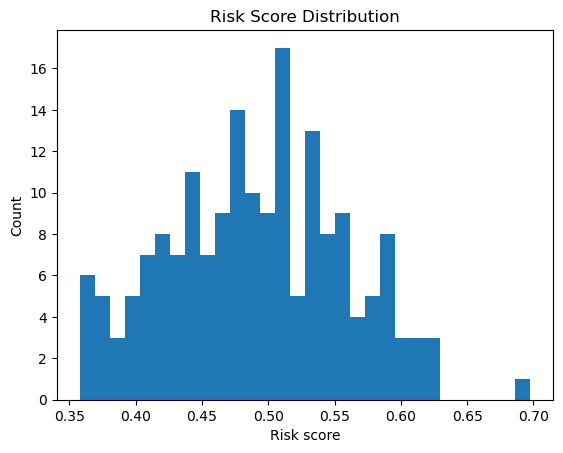

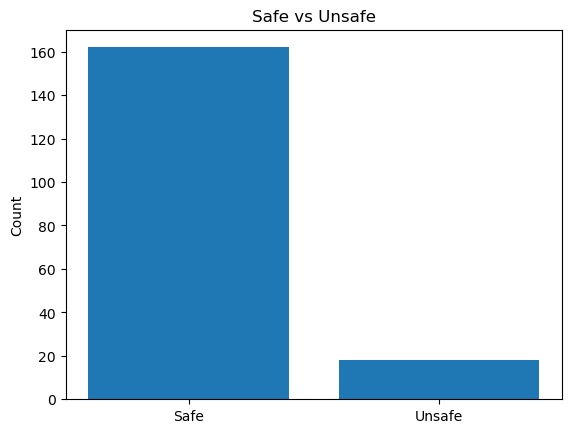

In [26]:
import matplotlib.pyplot as plt

scores = [score for _, score, _ in results]
labels = [label for _, _, label in results]

plt.figure()
plt.hist(scores, bins=30)
plt.title("Risk Score Distribution")
plt.xlabel("Risk score")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.bar(["Safe", "Unsafe"], [labels.count("Safe"), labels.count("Unsafe")])
plt.title("Safe vs Unsafe")
plt.ylabel("Count")
plt.show()


In [27]:
choice = ""
while choice != "4":
    print("\nMenu:")
    print("1) Show top 5 worst samples")
    print("2) Show first 5 unsafe alerts (generator)")
    print("3) Print model thresholds/cutoff")
    print("4) Exit")
    choice = input("Choice: ").strip()

    if choice == "1":
        for s, score, label in summary["top5_worst"]:
            print(f"{label} score={score:.3f} -> {s}")

    elif choice == "2":
        # generator requirement
        for s, score in list(alert_generator(results))[:5]:
            print(f"ALERT score={score:.3f} -> {s}")

    elif choice == "3":
        print(cal_model)

    elif choice == "4":
        print("Done.")
    else:
        print("Invalid choice.")



Menu:
1) Show top 5 worst samples
2) Show first 5 unsafe alerts (generator)
3) Print model thresholds/cutoff
4) Exit
Unsafe score=0.698 -> WaterSample(id=1483, ts=2023-08-05T04:00:00, ph=8.17, turb=3.38, cond=53.34, DO=4.89, temp=19.65, sal=35.27, chl=1.42)
Unsafe score=0.628 -> WaterSample(id=1529, ts=2023-08-06T03:00:00, ph=8.16, turb=1.63, cond=53.32, DO=4.84, temp=19.86, sal=35.26, chl=1.26)
Unsafe score=0.621 -> WaterSample(id=1620, ts=2023-08-08T00:30:00, ph=8.17, turb=2.04, cond=52.06, DO=7.60, temp=19.24, sal=34.33, chl=4.00)
Unsafe score=0.619 -> WaterSample(id=1618, ts=2023-08-07T23:30:00, ph=8.18, turb=2.02, cond=52.04, DO=7.54, temp=19.26, sal=34.31, chl=3.64)
Unsafe score=0.618 -> WaterSample(id=1516, ts=2023-08-05T20:30:00, ph=8.16, turb=2.26, cond=53.27, DO=7.49, temp=20.23, sal=35.22, chl=3.23)

Menu:
1) Show top 5 worst samples
2) Show first 5 unsafe alerts (generator)
3) Print model thresholds/cutoff
4) Exit
WaterQualityModel(cutoff=0.5835895357034179)

Menu:
1) Show

In [28]:
if __name__ == "__main__":
    print("Notebook is running as __main__")


Notebook is running as __main__
